<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Basic-Functions" data-toc-modified-id="Basic-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic Functions</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#DD-SIMCA-Overall-Model-(all-years)" data-toc-modified-id="DD-SIMCA-Overall-Model-(all-years)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DD-SIMCA Overall Model (all years)</a></span><ul class="toc-item"><li><span><a href="#All-analytes" data-toc-modified-id="All-analytes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>All analytes</a></span></li><li><span><a href="#Only->80%->LOD" data-toc-modified-id="Only->80%->LOD-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Only &gt;80% &gt;LOD</a></span></li><li><span><a href="#Top-k-variance" data-toc-modified-id="Top-k-variance-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Top k variance</a></span></li><li><span><a href="#Decorrelation-via-Hierarchical-Clustering" data-toc-modified-id="Decorrelation-via-Hierarchical-Clustering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Decorrelation via Hierarchical Clustering</a></span></li></ul></li><li><span><a href="#PU-Learning" data-toc-modified-id="PU-Learning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PU Learning</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/PyChemAuth.git
    !cd PyChemAuth; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import PyChemAuth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import copy

shap.initjs()

Overview
--------
This notebook illustrates the analysis of stable isotope and trace element data for strawberries.  This data was provided by Nives Ogrinc.

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-175-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

imblearn  : 0.9.0
sklearn   : 0.0
shap      : 0.40.0
watermark : 2.3.0
matplotlib: 3.5.1
json      : 2.0.9
pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.21.5
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]



# Basic Functions

In [4]:
from sklearn.model_selection import learning_curve

def plot_lc(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        random_state=42,
        shuffle=True, # If you set this to False you see an improvement suggesting there is a trend over time
        cv=cv,  
        n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.plot(
        train_sizes,
        train_mean,
        color="blue",
        marker="o",
        markersize=5,
        label="Training accuracy",
    )

    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha=0.15,
        color="blue",
    )

    plt.plot(
        train_sizes,
        test_mean,
        color="green",
        linestyle="--",
        marker="s",
        markersize=5,
        label="Validation accuracy",
    )

    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15,
        color="green",
    )

    plt.grid()
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

In [23]:
def manual_lc(estimator, X_tot, y_tot, X_out, train_sizes, cv):
    X_tot = sklearn.utils.shuffle(X_tot, random_state=0)
    
    kfold = sklearn.model_selection.KFold(n_splits=cv, shuffle=True, random_state=0)
    accuracies = []
    for train_index, test_index in kfold.split(X_tot):
        X_train = X_tot[train_index]
        y_train = y_tot[train_index]
        X_test = X_tot[test_index]
        y_test = y_tot[test_index]
        performance = []
        for frac in train_sizes:
            mask = np.array([False]*len(X_train))
            mask[:int(frac*len(X_train))] = True
            X = X_train[mask]
            estimator.fit(X, y_train[mask])
            train_pred = estimator.predict(X)
            test_pred = estimator.predict(X_test) # Entire test set
            out_pred = estimator.predict(X_out) # Entire abroad set
            performance.append([
                np.sum(train_pred == True) / len(train_pred),
                np.sum(test_pred == True) / len(test_pred),
                np.sum(out_pred == False) / len(out_pred)
            ])
        accuracies.append(performance)
    accuracies = np.array(accuracies)

    plt.figure()

    plt.errorbar(x=train_sizes*len(X_tot)*(cv-1.0)/cv, 
                 y=np.mean(accuracies, axis=0)[:,0], 
                 yerr=np.std(accuracies, axis=0)[:,0], 
                 label='Training Set'
                )
    plt.errorbar(x=train_sizes*len(X_tot)*(cv-1.0)/cv, 
                 y=np.mean(accuracies, axis=0)[:,1], 
                 yerr=np.std(accuracies, axis=0)[:,1], 
                 label='Validation Set'
                )
    plt.errorbar(x=train_sizes*len(X_tot)*(cv-1.0)/cv, 
                 y=np.mean(accuracies, axis=0)[:,2], 
                 yerr=np.std(accuracies, axis=0)[:,2], 
                 label='Abroad Set'
                )
    plt.grid()
    plt.xlabel('Authentic Samples in Training')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

In [6]:
def impute(raw_df, lod_df, impute_elements):
    np.random.seed(0)

    X_raw = {}
    for year in [2018, 2019, 2020]:
        X = copy.copy(raw_df[raw_df['Harvest year'] == year])
        lod = lod_df[lod_df['Harvest year'] == year]
        for analyte in impute_elements:

            def randomly_impute(x):
                if np.isnan(x): # NaN was recorded for < LOD
                    return np.random.random()*float(lod[analyte])
                else:
                    return x

            X[analyte] = X[analyte].apply(randomly_impute)
        X_raw[year] = X
        
    return pd.concat([X_raw[yr] for yr in [2018, 2019, 2020]])

In [7]:
def run(df, site_elements):
    X_train, X_test, y_train, y_test = train_test_split(
        df[df['Origin'] == 'Authentic SLO'][site_elements].values,
        df[df['Origin'] == 'Authentic SLO']['Origin'].values,
        test_size=0.30, 
        random_state=0,
        shuffle=True
    )
    
    pipeline = imblearn.pipeline.Pipeline(steps=[
        # Insert other preprocessing steps here...
        # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class="Authentic SLO", 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    param_grid = [{
        'simca__n_components':np.arange(1, 20, 2),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True]
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.KFold(
            n_splits=5, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(
        X_train,
        y_train
    )
    
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    axes = axes.flatten()

    # Training Set
    ax = axes[0]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        X_train,
        y_train,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Training Set')

    # Unseen test Set
    ax = axes[1]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        X_test,
        y_test,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Test Set')

    # Consider "abroad"
    ax = axes[2]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        df[df['Origin'] == 'Abroad'][site_elements].values,
        df[df['Origin'] == 'Abroad']['Origin'].values,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Abroad Set')

    # Consider "unknowns"
    ax = axes[3]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        df[df['Origin'] == 'Test SLO'][site_elements].values,
        df[df['Origin'] == 'Test SLO']['Origin'].values,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Test SLO Set')

    plt.tight_layout()

    train_score = gs.score(X_train, y_train) # Pretty good results on training

    test_score = gs.score(X_test, y_test) # Similar for test set

    return gs, train_score, test_score

# Load Data

In [8]:
raw_df = pd.read_csv('./data/DB_strawberries_revised_data.csv')
lod_df = pd.read_csv('./data/DB_strawberries_revised_lod.csv')

In [9]:
lod_df # Limits of Detection for each year

,Sample type,Harvest year,18O,13C,15N,34S,Na,Mg,Al,P,...,As,Se,Rb,Sr,Mo,Cd,Cs,Ba,Hg,Pb
0,LOD,2018,NaN,NaN,NaN,NaN,2.4,0.0020,2.5,0.00045,...,3.0,2.5,0.015,0.130,10.0,1.00,1.0,0.045,0.4,15
1,LOD,2019,NaN,NaN,NaN,NaN,2.4,0.0020,2.5,0.00045,...,3.0,2.5,0.015,0.130,10.0,1.00,1.0,0.045,0.4,15
2,LOD,2020,NaN,NaN,NaN,NaN,1.1,0.0016,3.2,0.00030,...,1.7,3.0,0.173,0.173,3.5,0.25,0.6,0.173,0.3,10


In [10]:
site_elements = lod_df.columns.drop(['Sample type', 'Harvest year']).tolist() # Extract SITE labels

In [11]:
raw_df = raw_df[['Harvest year', 'Origin', 'Country'] + site_elements] # Reduce data frame to what we care about

In [12]:
# Which columns do we impute?  SI ratios do not have a LOD so ignore those.
impute_elements = lod_df.columns.drop(['Sample type', 'Harvest year', '18O', '13C', '15N', '34S'])

In [13]:
df = impute(raw_df, lod_df, impute_elements)

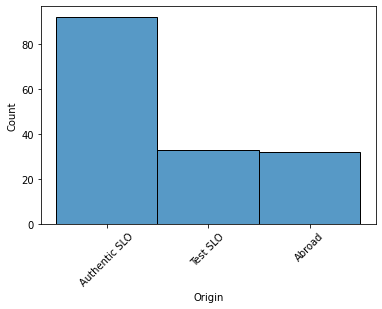

In [14]:
sns.histplot(df, x='Origin')
_ = plt.xticks(rotation=45)

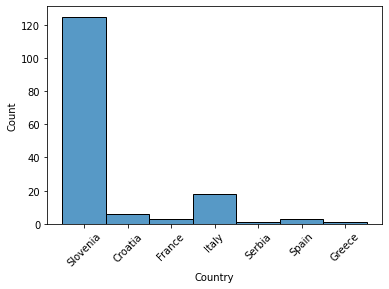

In [15]:
sns.histplot(df, x='Country')
_ = plt.xticks(rotation=45)

# DD-SIMCA Overall Model (all years)

In [16]:
from PyChemAuth.classifier.simca import SIMCA_Classifier

## All analytes

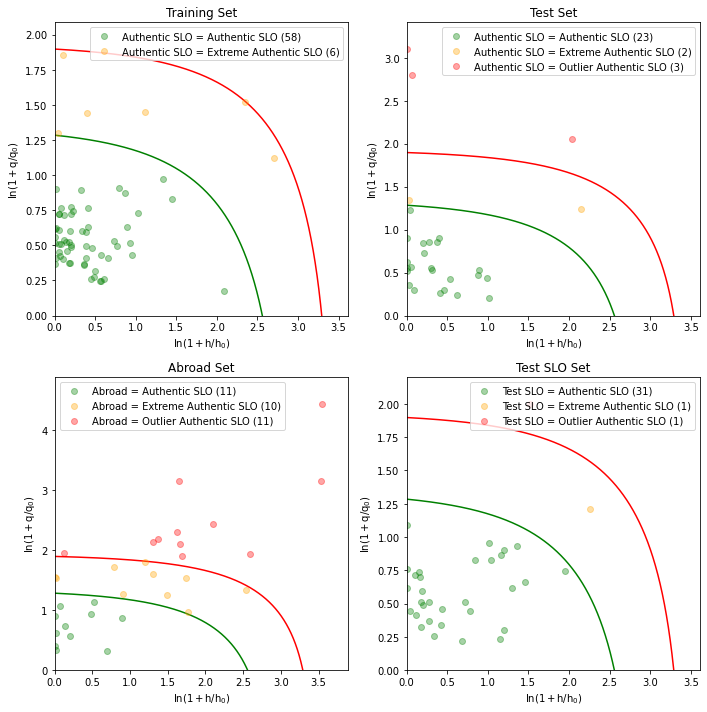

In [17]:
gs, _, _ = run(df, site_elements)

In [18]:
gs.best_params_

{'simca__alpha': 0.05,
 'simca__n_components': 1,
 'simca__scale_x': True,
 'simca__style': 'dd-simca'}

Text(0, 0.5, 'TEFF')

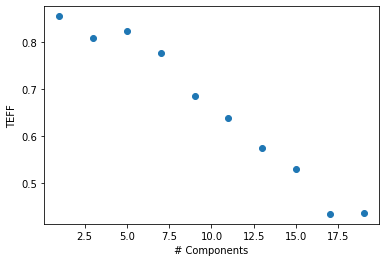

In [19]:
teff = gs.cv_results_['mean_test_score']
n = [d['simca__n_components'] for d in gs.cv_results_['params']]
plt.figure()
plt.plot(n, teff, 'o')
plt.xlabel('# Components')
plt.ylabel('TEFF')

In [20]:
# The "abroad" class should not be considered authentic, but performs quite poorly
gs.score(
    df[df['Origin'] == 'Abroad'][site_elements].values,
    df[df['Origin'] == 'Abroad']['Origin'].values
)

0.65625

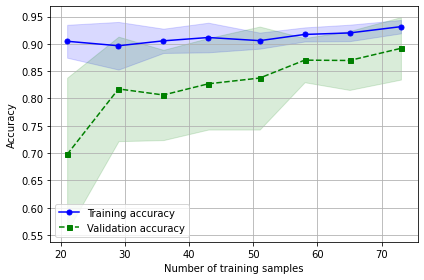

In [21]:
plot_lc(
    estimator=SIMCA_Classifier(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class="Authentic SLO",
            use='TEFF'
        ), 
    X=df[df['Origin'] == 'Authentic SLO'][site_elements].values, 
    y=df[df['Origin'] == 'Authentic SLO']['Origin'].values, 
    train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5)

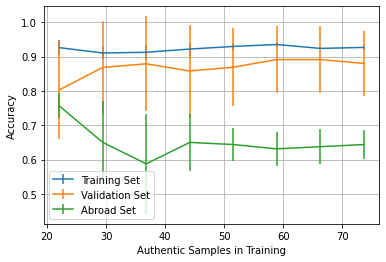

In [24]:
manual_lc(
    estimator=SIMCA_Classifier(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class="Authentic SLO",
            use='TEFF'
        ),
    X_tot = df[df['Origin'] == 'Authentic SLO'][site_elements].values,
    y_tot = df[df['Origin'] == 'Authentic SLO']['Origin'].values,
    X_out = df[df['Origin'] == 'Abroad'][site_elements].values,
    train_sizes = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
    cv=5
)

## Only >80% >LOD

In [25]:
raw_df[raw_df['Origin'] == 'Authentic SLO'].isna().sum()

Harvest year     0
Origin           0
Country          0
18O              0
13C              0
15N              0
34S              0
Na               2
Mg               0
Al              19
P                0
S                0
K                0
Ca               0
V               11
Cr              46
Mn               0
Fe               0
Co               0
Ni               9
Cu               0
Zn               0
As              18
Se              28
Rb               0
Sr               0
Mo               0
Cd               4
Cs               3
Ba               0
Hg              38
Pb              67
dtype: int64

In [26]:
bad_analytes = raw_df[raw_df['Origin'] == 'Authentic SLO'].isna().sum() / raw_df[raw_df['Origin'] == 'Authentic SLO'].shape[0] > 0.2
bad_analytes = bad_analytes.index[bad_analytes]

In [27]:
bad_analytes

Index(['Al', 'Cr', 'Se', 'Hg', 'Pb'], dtype='object')

In [28]:
df = impute(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           ) 

In [29]:
trimmed_elements = [e for e in site_elements if e not in bad_analytes]

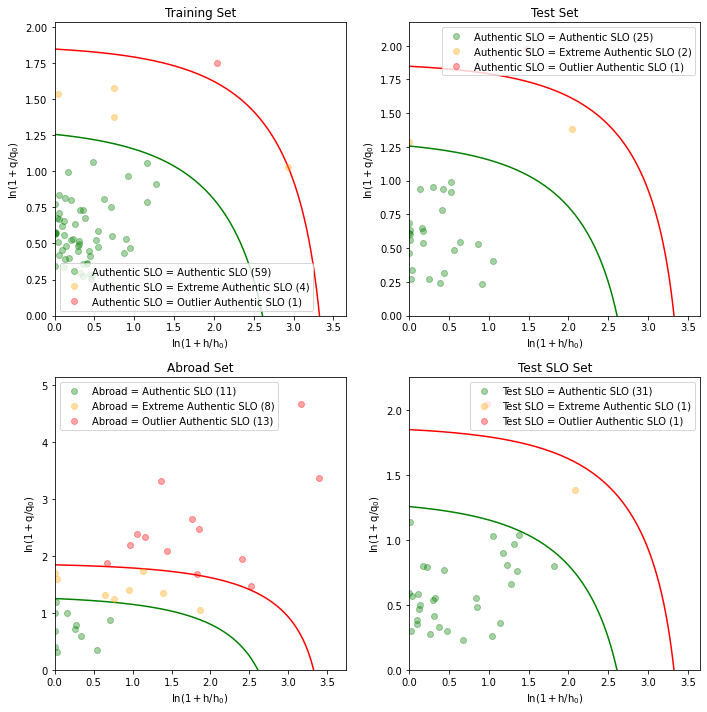

In [30]:
gs = run(df, trimmed_elements)

## Top k variance

In [32]:
df = impute(raw_df,
            lod_df, 
            impute_elements
           ) 

In [44]:
top_k = sorted([[k,v] for k,v in dict(df[site_elements].std()).items()], key=lambda x:x[1], reverse=True)
top_k

[['Ni', 366.6266667095986],
 ['Mo', 317.32754039544074],
 ['Cd', 75.1886515793055],
 ['Pb', 45.505917131426955],
 ['Na', 39.027389815307274],
 ['Co', 36.543451957938636],
 ['Cr', 32.51232687995594],
 ['Al', 29.164834540153695],
 ['As', 25.478559732855814],
 ['V', 22.67241330502358],
 ['Mn', 12.761849750920588],
 ['Cs', 11.984148121489648],
 ['Fe', 8.942000742657884],
 ['Se', 7.496649300186487],
 ['Zn', 3.827775089899667],
 ['Ba', 3.722879270941948],
 ['Sr', 3.707203096124729],
 ['Rb', 3.665870117161592],
 ['K', 3.1433371862910886],
 ['Hg', 3.0759426771331215],
 ['Cu', 2.305011961706006],
 ['34S', 2.2931130916761346],
 ['15N', 2.2898319979039647],
 ['18O', 2.135177705330965],
 ['13C', 0.8103520924639225],
 ['Ca', 0.46545973044157013],
 ['P', 0.4178267689466944],
 ['Mg', 0.26500246371772934],
 ['S', 0.120276138949636]]

In [46]:
# Let's just take the top 10
trimmed_elements = [e[0] for e in top_k[:10]]


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../PyChemAuth/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../PyChemAuth/classifier/simca.py", line 761, in fit
    raise Exception("Red

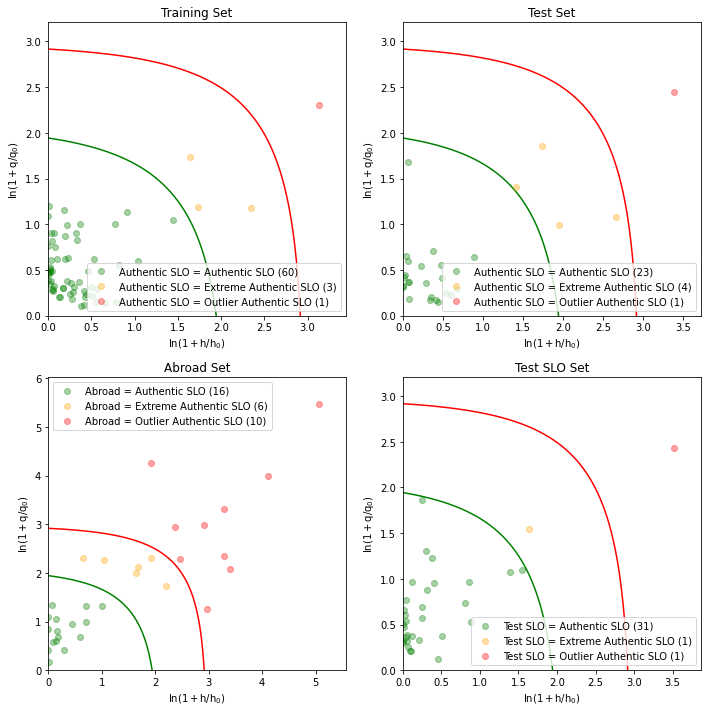

In [47]:
gs = run(df, trimmed_elements)

## Decorrelation via Hierarchical Clustering 

In [ ]:
# Analyze temporal trends in analytes

In [ ]:
## Individual Trends

In [ ]:
## Spearman R

In [ ]:
# Individual Years

In [ ]:
## 2018

In [ ]:
## 2019

In [ ]:
## 2020

# PU Learning